## Main Functions to generate fault characteristics, and sample points

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import random
import math


def random_unit_vector():
    # Generate random spherical coordinates
    theta = random.uniform(0, 2*math.pi)  # Azimuthal angle
    phi = random.uniform(0, math.pi)      # Polar angle

    # Convert spherical coordinates to Cartesian coordinates
    x = math.sin(phi) * math.cos(theta)
    y = math.sin(phi) * math.sin(theta)
    z = math.cos(phi)
    
    return (x, y, z)


def plane_main_axes_from_normal(normal): 
    # Find two axes of plane defined by the center and its normal
    length_axis = random_unit_vector()
    while np.dot(length_axis, normal) < 0.01:
        length_axis = random_unit_vector()

    length_axis = np.cross(normal, length_axis)
    length_axis = length_axis / np.linalg.norm(length_axis)
    width_axis = np.cross(normal, length_axis)

    return length_axis, width_axis


def display_fault_properties(fault_metadata):
    (center, length, width, normal, length_axis, width_axis) = fault_metadata
    print(f"\nDisplaying fault properties:")
    print(f"    Center: {center} \n    length: {length}, width: {width} \n     length_axis: {length_axis},   width_axis: {width_axis}")

In [22]:
def generate_faults_metadata(n_simple_faults, n_bent_faults, n_ladder_structures, eps_center=0.1, domain_scale=1, VERBOSE=False):
    """
    Generate metadata characterizing faults via a plane defined by a center, length, width, normal, length_axis, and width_axis.
    
    Args:
    - n_simple_faults:      number of simple planar faults to generate
    - n_bent_faults:        number of bent (bi-planar) faults to generate
    - n_ladder_structures:  number of ladder-like fault structures
    - eps_center:           minimum distance between fault centers
    - domain_scale:         scale=x denotes [-x,x]^3 space. 
    
    Returns:
    - faults_info: List of tuples containing fault metadata (center, length, width, normal, length_axis, width_axis)
    """
    
    # Set fault plane max length and width as proportion of domain
    L_max = 1.5 * domain_scale
    L_min = 1 * domain_scale
    W_max = 0.7 * domain_scale
    W_min= 0.5 * domain_scale
    faults_info = []
    
    # Generate simple fault data
    if VERBOSE:
        print(f"    Generating {n_simple_faults} simple faults:")
    for _ in range(n_simple_faults):
        while True:
            center = np.random.uniform(-domain_scale, domain_scale, size=3)
            if all(np.linalg.norm(center - c) > 2 * eps_center for c, _, _, _, _, _ in faults_info):  # Ensure centers aren't too close
                break
        length = np.random.uniform(L_min, L_max)
        width = np.random.uniform(W_min, W_max)
        normal = random_unit_vector()
        length_axis, width_axis = plane_main_axes_from_normal(normal)
        faults_info.append((center, length, width, normal, length_axis, width_axis))

        if VERBOSE:
            display_fault_properties((center, length, width, normal, length_axis, width_axis))

    # Generate bent fault data
    if VERBOSE:
        print(f"    Generating {n_bent_faults} bent faults:")
    for _ in range(n_bent_faults):
        while True:
            main_center = np.random.uniform(-domain_scale, domain_scale, size=3)
            if all(np.linalg.norm(main_center - c) > 2 * eps_center for c, _, _, _, _, _ in faults_info):  # Ensure centers aren't too close
                break
        # Generate main fault lengths, widths, and normal vector
        main_length = np.random.uniform(L_min, L_max)
        main_width = np.random.uniform(W_min, W_max)
        main_normal = random_unit_vector()
        main_length_axis, main_width_axis = plane_main_axes_from_normal(main_normal)
        faults_info.append((main_center, main_length, main_width, main_normal, main_length_axis, main_width_axis))

        if VERBOSE:
            print("Generated main plane:")
            display_fault_properties((main_center, main_length, main_width, main_normal, main_length_axis, main_width_axis))

        # Generate secondary smaller fault, sample plane at an angle
        bent_length = 0.7 * main_length
        bent_width = 0.7 * main_width 

        # sample angle in (-35,35) degrees between two fault planes
        angle = np.random.uniform(-40, 40, size=1)
        # find new plane long axis and normal
        desired_cosine = np.cos(np.radians(90-angle))
        alpha =  np.random.uniform(-1, 1) * desired_cosine / np.sqrt(1 + desired_cosine**2)

        bent_length_axis = main_length_axis  + alpha * main_normal 
        bent_length_axis = bent_length_axis / np.linalg.norm(bent_length_axis)
        bent_width_axis = main_width_axis 
        
        bent_center = main_center + 0.5*main_length*main_length_axis + 0.5*bent_length * bent_length_axis
        bent_normal = np.cross(bent_length_axis, bent_width_axis)

        faults_info.append((bent_center, bent_length, bent_width, bent_normal, bent_length_axis, bent_width_axis))

        if VERBOSE:
            print(f"Generated bent plane at desired angle: {angle}, calculated: {np.arccos(np.clip(np.dot(bent_length_axis, bent_width_axis) , -1.0, 1.0))} ")
            display_fault_properties((bent_center, bent_length, bent_width, bent_normal, bent_length_axis, bent_width_axis))


    # Generate ladder structures
    if VERBOSE:
        print(f"    Generating {n_ladder_structures} ladder-like structures:")
    for _ in range(n_ladder_structures):

        # Characterise the first main fault
        while True:
            first_center = np.random.uniform(-domain_scale, domain_scale, size=3)
            if all(np.linalg.norm(first_center - c) > 2 * eps_center for c, _, _, _, _, _ in faults_info):  # Ensure centers aren't too close
                break
        first_length = np.random.uniform(L_min, L_max)
        first_width = np.random.uniform(W_min, W_max)
        first_normal = random_unit_vector()
        first_length_axis, first_width_axis = plane_main_axes_from_normal(first_normal)
        faults_info.append((first_center, first_length, first_width, first_normal, first_length_axis, first_width_axis))            
        if VERBOSE:
            print(f" Ladder structure first main parallel fault")
            display_fault_properties((first_center, first_length, first_width, first_normal, first_length_axis, first_width_axis))

        # Characterise the second main fault
        dist_between_parallels = np.min(np.array([np.random.uniform(1.5*first_width, 3*first_width), 0.7*first_length]))
        second_center = first_center + dist_between_parallels * np.array(first_normal)
        second_length = first_length
        second_width = first_width
        second_normal = first_normal
        second_length_axis = first_length_axis
        second_width_axis = first_width_axis
        faults_info.append((second_center, second_length, second_width, second_normal, second_length_axis, second_width_axis))

        if VERBOSE:
            print(f" Ladder structure second main parallel fault")
            display_fault_properties((second_center, second_length, second_width, second_normal, second_length_axis, second_width_axis))

        # Characterise smaller, middle faults: 
        N_smaller_perpendicular_faults = 3
        dist_between_smaller_faults = first_length / N_smaller_perpendicular_faults

        mid_length = dist_between_parallels
        mid_width = dist_between_parallels / 2
        mid_normal = first_length_axis
        mid_length_axis = first_normal
        mid_width_axis = first_width_axis
    
        for i in range(N_smaller_perpendicular_faults):
            if i % 2 == 0:
                j = i // 2
            else:
                j = -((i + 1) // 2)
            mid_center = (first_center + second_center)/2 + j*dist_between_smaller_faults*first_length_axis

            faults_info.append((mid_center, mid_length, mid_width, mid_normal, mid_length_axis, mid_width_axis))
            if VERBOSE:
                print(f" Adding smaller middle perpendicular fault number {i}")
                display_fault_properties((mid_center, mid_length, mid_width, mid_normal, mid_length_axis, mid_width_axis))
        
    return faults_info

In [23]:
def generate_points_from_plane(center, length, width, normal, length_axis, width_axis, num_points=100, distribution_mode='normal', domain_scale=1):
    # Sample 100 points on the plane, and sample a distance for each point from the plane
    x = np.random.uniform(-length/2, length/2, num_points).astype(float)
    y = np.random.uniform(-width/2, width/2, num_points).astype(float)

    # Sample distances from the plane
    # Convention for faults: mean distance ~ width => 4*sigma=width
    if distribution_mode == 'normal':
        distribution_param = width/5
        dist = np.random.normal(loc=0, scale=distribution_param, size=num_points)

    # Compute fault points
    fault_points = center + x[:, None] * length_axis + y[:, None] * width_axis + dist[:, None] * normal

    return fault_points


def generate_point_list_from_metadata_list(fault_metadata_list, n_simple_faults, n_bent_faults):
     
    """
    Generate point cloud for every fault given its metadata.

    Args:
    - fault_metadata_list: metadata for each fault, ordered by first simple faults, then bent faults (2*n_bent_faults), then faults belonging to structures (n_structure_faults)

    Returns:
    - faults_info: List of tuples containing fault metadata (center, length, width, normal, length_axis, width_axis)
    """
    points_list = []
    k = 0
    for i, metadata in enumerate(fault_metadata_list):
        # Add simple faults
        if i <= n_simple_faults-1 or i >= n_simple_faults + 2 * n_bent_faults: 
            (center, length, width, normal, length_axis, width_axis) = metadata
            points_list.append(generate_points_from_plane(center, length, width, normal, length_axis, width_axis))

        # Add bent faults, make sure to merge main-bent points into one list
        else: 
            if k%2 == 0: # main points
                (main_center, main_length, main_width, main_normal, main_length_axis, main_width_axis) = metadata
                main_fault_points = generate_points_from_plane(main_center, main_length, main_width, main_normal, main_length_axis, main_width_axis)
                k+=1
            else:        # bent points
                (bent_center, bent_length, bent_width, bent_normal, bent_length_axis, bent_width_axis) = metadata
                bent_fault_points = generate_points_from_plane(bent_center, bent_length, bent_width, bent_normal, bent_length_axis, bent_width_axis)

                # Concatenate main and bent points into one array, and add to list.
                points_list.append(np.concatenate((main_fault_points, bent_fault_points)))
                k+=1

    return points_list


def generate_dataset(n_simple_faults, n_bent_faults, n_structures, VERBOSE=False):

    fault_metadata = generate_faults_metadata(n_simple_faults, n_bent_faults, n_structures, eps_center=0.1, domain_scale=1, VERBOSE=False)

    fault_points_list = generate_point_list_from_metadata_list(fault_metadata_list, n_simple_faults, n_bent_faults)
    
    return fault_points_list

### Visualization functions

In [24]:
def multi_static_plot_better(fault_points_list, fault_metadata_list=None, show_plane=False, show_axes=False):
    """
    Visualize fault points in 3D and optionally plot the plane and axes.

    Args:
    - fault_points_list: List of fault points arrays (each array represents points for one fault)
    - fault_metadata_list: List of fault metadata tuples (each tuple contains metadata for one fault)
    - show_plane: Boolean indicating whether to plot the plane (default is False)
    - show_axes: Boolean indicating whether to plot the axes (default is False)
    """
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot event points for each fault
    for i, fault_points in enumerate(fault_points_list):
        ax.scatter(fault_points[:, 0], fault_points[:, 1], fault_points[:, 2], label=f'Fault {i+1}', s=5)

    # Plot the plane and axes if requested
    if show_plane or show_axes or fault_metadata_list != None:
        for metadata in fault_metadata_list:
            # Unpack plane data
            (center, length, width, normal, length_axis, width_axis) = metadata

            if show_plane:
                # Define vertices of the plane
                plane_vertices = center + np.array([-length/2, length/2, length/2, -length/2, -length/2])[:, None] * length_axis + np.array([-width/2, -width/2, width/2, width/2, -width/2])[:, None] * width_axis

                # Plot the plane
                ax.plot_trisurf(plane_vertices[:, 0], plane_vertices[:, 1], plane_vertices[:, 2], color='blue', alpha=0.2)

            if show_axes:
                # Plot length and width axes
                ax.plot([center[0], center[0] + length_axis[0]*length/2],
                        [center[1], center[1] + length_axis[1]*length/2],
                        [center[2], center[2] + length_axis[2]*length/2], color='red', linewidth=3)

                ax.plot([center[0], center[0] + width_axis[0]*width/2],
                        [center[1], center[1] + width_axis[1]*width/2],
                        [center[2], center[2] + width_axis[2]*width/2], color='green', linewidth=3)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Synthetic Seismic Data - Fault Points')
    ax.legend()
    plt.show()

In [25]:
def multi_interactive_plot_better(fault_points_list, fault_metadata_list=None, show_plane=False, show_axes=False, domain_scale=1):
    """
    Visualize 3D points of multiple faults in an interactive plot using Plotly.
    """

    fig = go.Figure()

    x_range_largest = [-1, 1]
    y_range_largest = x_range_largest
    z_range_largest = x_range_largest
    
    for i, points in enumerate(fault_points_list):
        # Extract x, y, z coordinates from points
        x_coords = points[:, 0]
        y_coords = points[:, 1]
        z_coords = points[:, 2]

        # Plot the points
        fig.add_trace(go.Scatter3d(
            x=x_coords,
            y=y_coords,
            z=z_coords,
            mode='markers',
            marker=dict(
                size=3,
                opacity=0.8
            ),
            name=f'Fault {i+1}'
        ))

    if show_plane or show_axes or fault_metadata_list != None:
        for j, metadata in enumerate(fault_metadata_list):
            # Unpack plane data:
            (center, length, width, normal, length_axis, width_axis) = metadata

            if show_plane:
                # Define vertices of the plane
                plane_vertices = center + np.array([-length/2, length/2, length/2, -length/2, -length/2])[:, None] * length_axis + np.array([-width/2, -width/2, width/2, width/2, -width/2])[:, None] * width_axis

                plane_trace = go.Mesh3d(x=plane_vertices[:, 0],
                                        y=plane_vertices[:, 1],
                                        z=plane_vertices[:, 2],
                                        i=[0, 1, 2, 0],
                                        j=[1, 2, 3, 4],
                                        k=[2, 3, 4, 0],
                                        opacity=0.2,
                                        color='blue',
                                        )
                fig.add_trace(plane_trace)

            if show_axes:
                # Plot length and width axes
                length_axis_trace = go.Scatter3d(x=[center[0], center[0] + length_axis[0]*length/2],
                                                y=[center[1], center[1] + length_axis[1]*length/2],
                                                z=[center[2], center[2] + length_axis[2]*length/2],
                                                mode='lines',
                                                line=dict(color='red', width=3),
                                                )

                width_axis_trace = go.Scatter3d(x=[center[0], center[0] + width_axis[0]*width/2],
                                                y=[center[1], center[1] + width_axis[1]*width/2],
                                                z=[center[2], center[2] + width_axis[2]*width/2],
                                                mode='lines',
                                                line=dict(color='green', width=3),
                                                )
                fig.add_trace(length_axis_trace)
                fig.add_trace(width_axis_trace)

    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'),
        title='3D Visualization of Fault Points'
    )

    fig.show()

## Example outputs

### Example Simple Fault

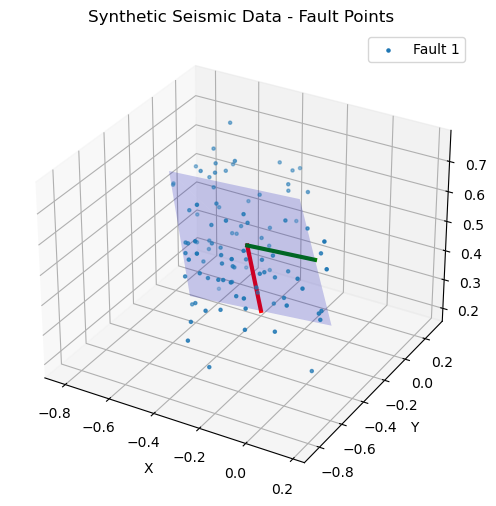

In [26]:
n_simple_faults = 1
n_bent_faults = 0
n_structures = 0

# Generate fault metadata 
fault_metadata_list = generate_faults_metadata(n_simple_faults, n_bent_faults, n_structures, eps_center=0.1, domain_scale=1, VERBOSE=False)

# Generate point cloud for the fault 
fault_points_list = generate_point_list_from_metadata_list(fault_metadata_list, n_simple_faults, n_bent_faults)

# Plot 
multi_static_plot_better(fault_points_list, fault_metadata_list, show_plane=True, show_axes=True)
#simple_interactive_plot(fault_points, fault_metadata[0], show_plane=True, show_axes=True)

### Example Bent Fault

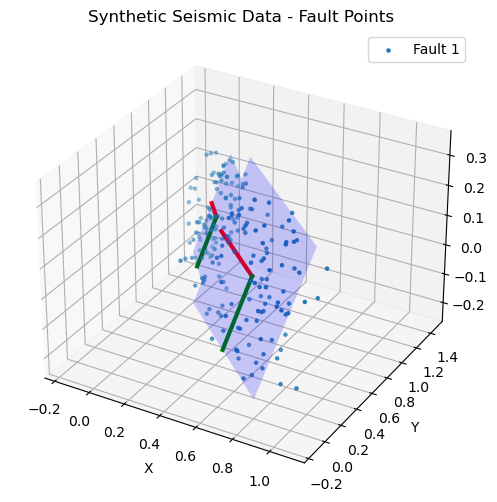

In [27]:
n_simple_faults = 0
n_bent_faults = 1
n_structures = 0

# Generate fault metadata 
fault_metadata_list = generate_faults_metadata(n_simple_faults, n_bent_faults, n_structures, eps_center=0.1, domain_scale=1, VERBOSE=False)

# Generate point cloud for the fault 
fault_points_list = generate_point_list_from_metadata_list(fault_metadata_list, n_simple_faults, n_bent_faults)


# Plot 
multi_static_plot_better(fault_points_list, fault_metadata_list, show_plane=True, show_axes=True)
#simple_interactive_plot_better(fault_points, fault_metadata, show_plane=True, show_axes=True)

### Example ladder structure (with 3 smaller 'rung' faults)

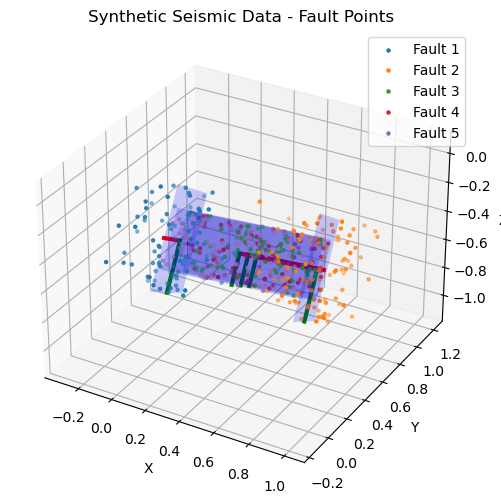

In [28]:
n_simple_faults = 0
n_bent_faults = 0
n_structures = 1

# Generate list of fault metadata 
fault_metadata_list = generate_faults_metadata(n_simple_faults, n_bent_faults, n_structures, eps_center=0.1, domain_scale=1, VERBOSE=False)

# Generate point cloud for the fault 
fault_points_list = generate_point_list_from_metadata_list(fault_metadata_list, n_simple_faults, n_bent_faults)

# Plot 
multi_static_plot_better(fault_points_list, fault_metadata_list, show_plane=True, show_axes=True)
#simple_interactive_plot_better(fault_points, fault_metadata, show_plane=True, show_axes=True)

### Example with many faults

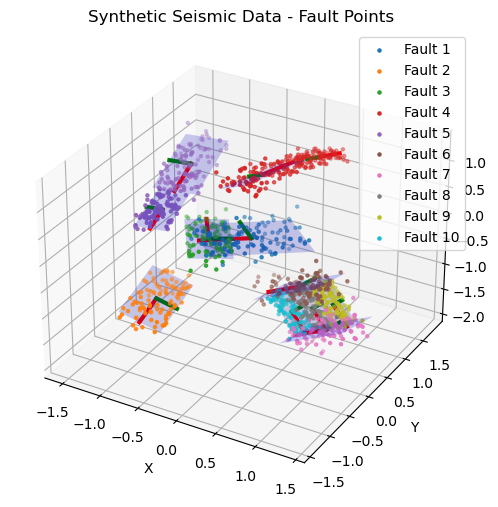

In [29]:
n_simple_faults = 3
n_bent_faults = 2
n_structures = 1

# Generate fault metadata 
fault_metadata_list = generate_faults_metadata(n_simple_faults, n_bent_faults, n_structures, eps_center=0.1, domain_scale=1, VERBOSE=False)

# Generate point cloud for the fault 
fault_points_list = generate_point_list_from_metadata_list(fault_metadata_list, n_simple_faults, n_bent_faults)

# Plot 
multi_static_plot_better(fault_points_list, fault_metadata_list, show_plane=True, show_axes=True)
#simple_interactive_plot_better(fault_points, fault_metadata, show_plane=True, show_axes=True)

## Generating a larger dataset

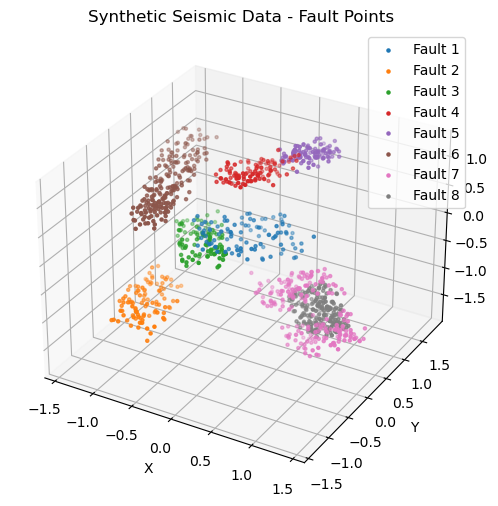

In [30]:
fault_points_list = generate_dataset(n_simple_faults=5, n_bent_faults= 4, n_structures= 0, VERBOSE=False)

multi_static_plot_better(fault_points_list, None, show_plane=False, show_axes=False)